# 论文名称-An aritifical neuron implemented on an actual quantum processor

## 项目介绍

 论文中介绍了一种量子感知器算法，可以用来模式识别。首先量子感知器包含三个部分(全部有量子线路组成), 输入线路 $U_i$, 训练线路 $U_w$ 和激活函数线路。一开始，初始量子比特都为 $|0\rangle$, 先经过 Hadamad 门。如果是2两个量子比特，量子态变为 $\frac{1}{2}(|00\rangle + |01\rangle + |10\rangle + |11\rangle)$ 线路经过 $U_i$ 后不会改变每个量子态的振幅，但是会改变其中某个量子态的相位，前面加个-1。所以量子态经过 $U_{in}$ 后有 $2^{4}=16$ 种。然后经过 $U_w$ , $U_w$也是改变前面的量子态的相位。如果 $U_w$ 可以识别前面的 $U_i$, 每个量子态前面的相位又都变为1, 再经过 Hadamad 门, 量子态全部变为 $|0\rangle$ 态，在线路中加入X 门翻转量子比特，0态变1态。激活函数为Toffili 门, 最后通过测量辅助比特为态的概率来判断相应的输入模式有没有被识别。

![circ](./src/circuit.png)

## 复现过程

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.quantum_perceptron import  perceptron
plt.rcParams["figure.dpi"]=200


[WARNING] ME(154267:139831320220992,MainProcess):2023-10-17-16:14:37.800.925 [mindspore/run_check/_check_version.py:102] MindSpore version 2.1.0 and cuda version 11.8.89 does not match, CUDA version [['10.1', '11.1', '11.6']] are supported by MindSpore officially. Please refer to the installation guide for version matching information: https://www.mindspore.cn/install.


#### 文献中用 hypergraph state 来实现所有的 $U_{in}$ 和 $U_w$ 的量子线路。对于4个量子比特，用到的的门为: z门、控制z门、两比特控制z门和三比特控制z门的组合。这四种门在4条量子线路里有 $2^{15}$种组合，这些组合线路经过 Hadamad 门的量子态(有全局相位-1或没有)会产生 $2^{16}$种输入量子线路。

In [2]:
z_combinations,  control_z_combinations, control_2_z_combinatons, control_3_z_combinations = perceptron.gate_combinations()

data_circuits_input, data_circuits_weight = perceptron.data_circuits(z_combinations,  control_z_combinations, control_2_z_combinatons, control_3_z_combinations)
circ_state_information = perceptron.circuit_state(data_circuits_input)

### 用字典将 $U_{in}$的态信息和量子线路对应

In [3]:
input_dataset = dict(zip(circ_state_information,data_circuits_input))  ### 全部的
weight_dataset = dict(zip(circ_state_information,data_circuits_weight)) 

set_lst=set(circ_state_information) # 判断有没有重复的数据
print("考虑线路对称性后,量子线路有2^15:  %d种" %(len(set_lst)))
print(len(set_lst))

positive_data, training_data, traing_label = perceptron.training_data(input_dataset)
print("正样本的数量有:%d个 " %(len(positive_data)))

考虑线路对称性后,量子线路有2^15:  32768种
32768
正样本的数量有:44个 


In [4]:
 # random weight vector
w_vector = (1,1,1,0,
                0,0,0,1,
                1,0,1,0,
                0,0,0,1)
w_t = []
w_t_matrix = []
w_final = []
for index, in_vector in enumerate(training_data):

    input_circuits = input_dataset[in_vector]
    try:
        weight_circuits = weight_dataset[w_vector]
    except :
        print("输入的初始w0没有对应的量子线路")
    pred = perceptron.active_function(input_circuits, weight_circuits)
    labels = traing_label[in_vector]

    w_vector = perceptron.update(in_vector, w_vector, pred, input_dataset, weight_dataset)
    w_t.append(w_vector)
    if index%10 == 1:
        print("This is the %dth 循环"%(index))

w_final_matrix = np.array(list(w_vector)).reshape(4,4)
for i in w_t:
    w_t_matrix.append(np.array(list(i)).reshape(4,4))
print("通过训练后最终的w_t是: ")
print(w_final_matrix)

This is the 1th 循环
This is the 11th 循环
This is the 21th 循环
This is the 31th 循环
This is the 41th 循环
This is the 51th 循环
This is the 61th 循环
This is the 71th 循环
This is the 81th 循环
This is the 91th 循环
This is the 101th 循环
This is the 111th 循环
This is the 121th 循环
This is the 131th 循环
This is the 141th 循环
This is the 151th 循环
This is the 161th 循环
This is the 171th 循环
This is the 181th 循环
This is the 191th 循环
This is the 201th 循环
This is the 211th 循环
This is the 221th 循环
This is the 231th 循环
This is the 241th 循环
This is the 251th 循环
This is the 261th 循环
This is the 271th 循环
This is the 281th 循环
This is the 291th 循环
This is the 301th 循环
This is the 311th 循环
This is the 321th 循环
This is the 331th 循环
This is the 341th 循环
This is the 351th 循环
This is the 361th 循环
This is the 371th 循环
This is the 381th 循环
This is the 391th 循环
This is the 401th 循环
This is the 411th 循环
This is the 421th 循环
This is the 431th 循环
This is the 441th 循环
This is the 451th 循环
This is the 461th 循环
This is the 471th 循环
Thi

In [5]:
weight_target_circuits = weight_dataset[w_vector]
correct = 0
for in_vector in tqdm(training_data):
    input_circuits = input_dataset[in_vector]
    pred = perceptron.active_function(input_circuits, weight_target_circuits)
    if traing_label[in_vector] == pred:
        correct += 1
correct_radio = correct/len(training_data)

100%|██████████| 544/544 [00:02<00:00, 259.90it/s]


In [6]:
print("目标w对所有样本的识别率为: %f4"%(correct_radio))

目标w对所有样本的识别率为: 0.9522064


### 复现的论文中图5训练过程，对于给定的输入可以实现99.8%的识别率，论文中负样本选取了3000个，因为训练数据太多比较耗时，这里选取了500个负样本，同样可以训练出目标w。因为所产生的负样本的训练数据有一个或两个态也可以被w识别，所以没有实现100%识别率。

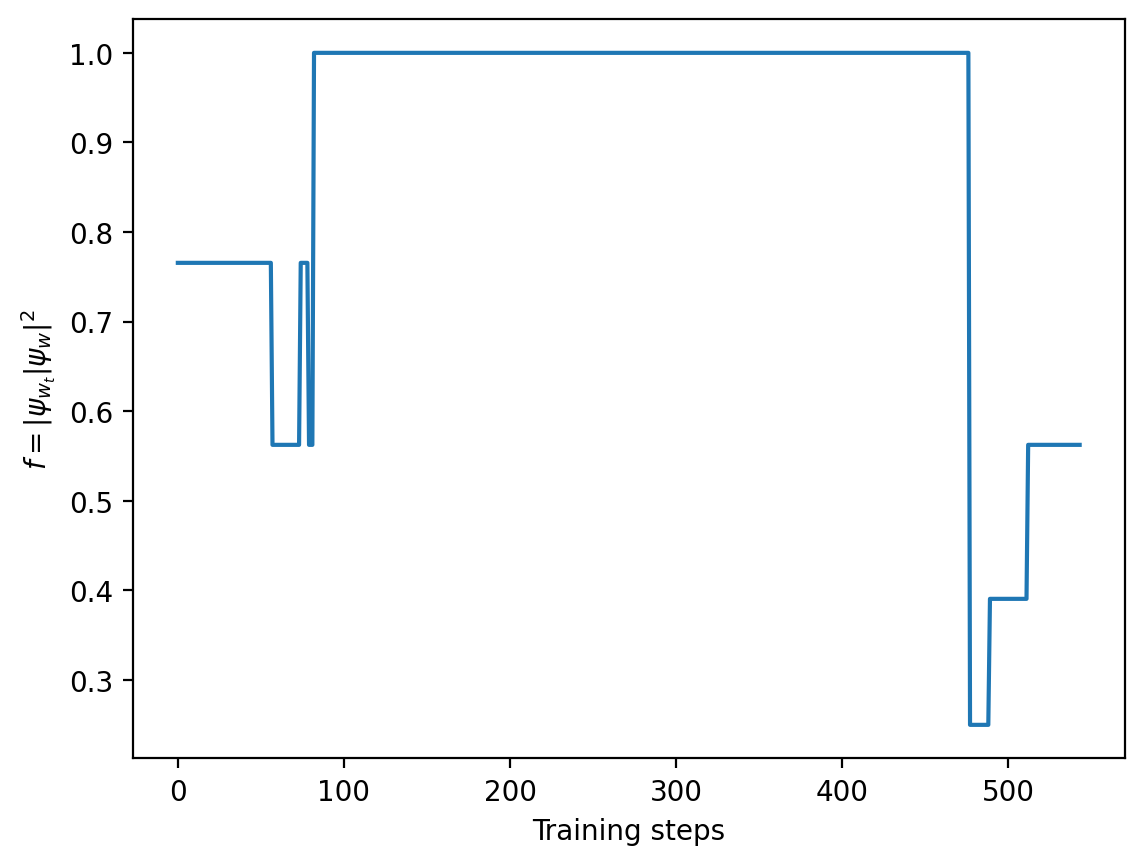

In [7]:
psi_w = 0.25*np.array([1, 1, 1, 1,
                       1, 1, -1, 1,
                       1, -1, -1, -1,
                       1, 1, -1, 1])
psi_wt = []
fidelity = []
for i in w_t:
    psi = np.ones(16)
    for index, j in enumerate(i):
        if j == 0:
            psi[index] = -1
    psi_wt.append(0.25*psi)

for i in range(len(w_t)):
    fidelity.append((psi_wt[i].dot(psi_w))**2)

#print("最后得到的训练每一步的w_t和目标w的fedility")
steps = np.arange(0, len(w_t), 1)
plt.plot(steps, fidelity)
plt.xlabel("Training steps")
plt.ylabel(r"$f=|\psi_{w_t}|\psi_w|^2$")
plt.show()

## 项目总结

简要总结一下您复现的论文、您的复现结果、创新点和未来可继续研究的方向。



这篇文章输入线路和所要训练的线路都不改变量子态的振幅，通过训练可以实现对量子态的识别。未来可以继续研究的方向在于能不能改变量子态的振幅，实现对更多量子态的识别。